# Machine Learning meets Climate Change

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import folium
import imageio
from tqdm import tqdm_notebook
from folium.plugins import MarkerCluster
import imageio
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import scipy
from itertools import product
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [2]:
data = pd.read_csv('CleanedGlobalLandTemperaturesByMajorCity.csv')

# Create List of Cities

In [3]:
top_5_coldest = list(data.City.unique())
top_5_coldest

['Changchun', 'Harbin', 'Montreal', 'Moscow', 'Saint Petersburg']

# Data Visualization

In [4]:
# city_data = data

In [5]:
data.head()

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,48243,1921-01-01,6.9908,1.021,Changchun,China,44.20N,125.22E
1,48244,1921-02-01,11.9930,0.593,Changchun,China,44.20N,125.22E
2,48245,1921-03-01,24.1394,0.278,Changchun,China,44.20N,125.22E
3,48246,1921-04-01,43.6406,0.700,Changchun,China,44.20N,125.22E
4,48247,1921-05-01,59.3456,0.480,Changchun,China,44.20N,125.22E


In [6]:
city = "Changchun"

In [7]:
city_data = data[data['City']== city]

In [8]:
city_data.head()

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,48243,1921-01-01,6.9908,1.021,Changchun,China,44.20N,125.22E
1,48244,1921-02-01,11.9930,0.593,Changchun,China,44.20N,125.22E
2,48245,1921-03-01,24.1394,0.278,Changchun,China,44.20N,125.22E
3,48246,1921-04-01,43.6406,0.700,Changchun,China,44.20N,125.22E
4,48247,1921-05-01,59.3456,0.480,Changchun,China,44.20N,125.22E


In [9]:
data.shape

(5565, 8)

# Create Year Month day and weekday columns to fit machine learning models

In [10]:
city_data = city_data.reset_index()

In [11]:
city_data = city_data.drop(columns=['index'])

In [12]:
city_data.dt = pd.to_datetime(city_data.dt)

In [13]:
YEAR = []
MONTH = []
DAY = []
WEEKDAY = []
for i in range(len(city_data)):
    WEEKDAY.append(city_data.dt[i].weekday())
    DAY.append(city_data.dt[i].day)
    MONTH.append(city_data.dt[i].month)
    YEAR.append(city_data.dt[i].year)

In [14]:
city_data['Year'] = YEAR
city_data['Month'] = MONTH
city_data['Day'] = DAY 
city_data['Weekday'] = WEEKDAY

In [15]:
change_year_index = []
change_year = []
year_list = city_data['Year'].tolist()
for y in range(0,len(year_list)-1):
    if year_list[y]!=year_list[y+1]:
        change_year.append(year_list[y+1])
        change_year_index.append(y+1)

In [16]:
city_data.loc[change_year_index].head()
city_data

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Year,Month,Day,Weekday
0,48243,1921-01-01,6.9908,1.021,Changchun,China,44.20N,125.22E,1921,1,1,5
1,48244,1921-02-01,11.9930,0.593,Changchun,China,44.20N,125.22E,1921,2,1,1
2,48245,1921-03-01,24.1394,0.278,Changchun,China,44.20N,125.22E,1921,3,1,1
3,48246,1921-04-01,43.6406,0.700,Changchun,China,44.20N,125.22E,1921,4,1,4
4,48247,1921-05-01,59.3456,0.480,Changchun,China,44.20N,125.22E,1921,5,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1108,49351,2013-05-01,64.2164,0.377,Changchun,China,44.20N,125.22E,2013,5,1,2
1109,49352,2013-06-01,71.1338,0.626,Changchun,China,44.20N,125.22E,2013,6,1,5
1110,49353,2013-07-01,75.6824,0.378,Changchun,China,44.20N,125.22E,2013,7,1,0
1111,49354,2013-08-01,73.6034,0.369,Changchun,China,44.20N,125.22E,2013,8,1,3


In [17]:
x_ticks_year_list=np.linspace(min(year_list),max(year_list),10).astype(int)
change_year_index = np.array(change_year_index)
x_ticks_year_index = []
for i in range(1,len(x_ticks_year_list)):
    x_ticks_year_index.append(change_year_index[np.where(np.array(change_year)==x_ticks_year_list[i])][0])

In [18]:
last_year_data = city_data[city_data.Year>=2010].reset_index().drop(columns=['index'])
P = np.linspace(0,len(last_year_data)-1,5).astype(int)

In [19]:
def get_timeseries(start_year,end_year):
    last_year_data = city_data[(city_data.Year>=start_year) & (city_data.Year<=end_year)].reset_index().drop(columns=['index'])
    return last_year_data

In [20]:
def plot_timeseries(start_year,end_year):
    last_year_data = get_timeseries(start_year,end_year)
    P = np.linspace(0,len(last_year_data)-1,5).astype(int)
    plt.plot(last_year_data.AverageTemperature,marker='.',color='firebrick')
    plt.xticks(np.arange(0,len(last_year_data),1)[P],last_year_data.dt.loc[P],rotation=60)
    plt.xlabel('Date (Y/M/D)')
    plt.ylabel('Average Temperature')

In [21]:
def plot_from_data(data,time,c='firebrick',with_ticks=True,label=None):
    time = time.tolist()
    data = np.array(data.tolist())
    P = np.linspace(0,len(data)-1,5).astype(int)
    time = np.array(time)
    if label==None:
        plt.plot(data,marker='.',color=c)
    else:
        plt.plot(data,marker='.',color=c,label=label)
    if with_ticks==True:
        plt.xticks(np.arange(0,len(data),1)[P],time[P],rotation=60)
    plt.xlabel('Date (Y/M/D)')
    plt.ylabel('Average Temperature')

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


(2.0, 22.0)

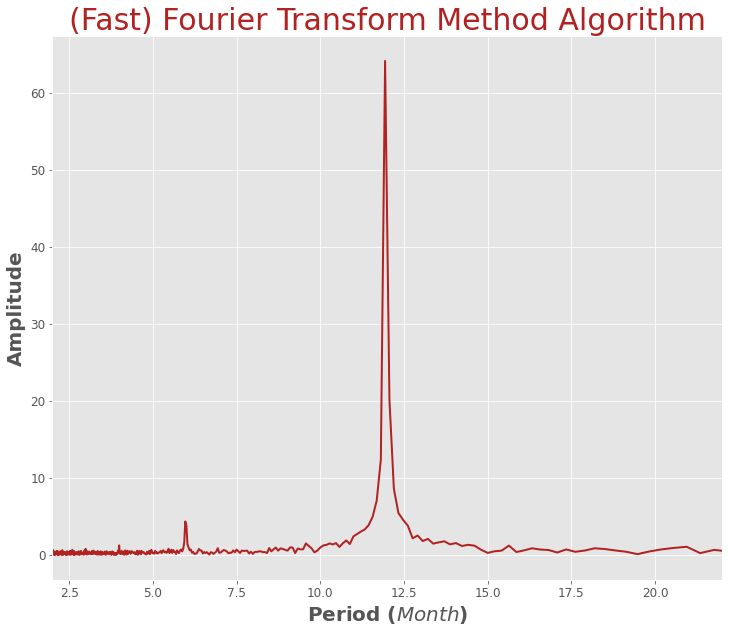

In [22]:
FFT = np.fft.fft(city_data.AverageTemperature)
FFT_abs = np.abs(FFT)
new_N=int(len(FFT)/2) 
f_nat=1
new_X = np.linspace(0, f_nat/2, new_N, endpoint=True)
new_X = 1/new_X
plt.plot(new_X,2*FFT_abs[0:int(len(FFT)/2.)]/len(new_X),color='firebrick')
plt.xlabel('Period ($Month$)',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)
plt.title('(Fast) Fourier Transform Method Algorithm',fontsize=30,color='firebrick')
plt.grid(True)
plt.xlim(2,22)

# Checking on Stationarity

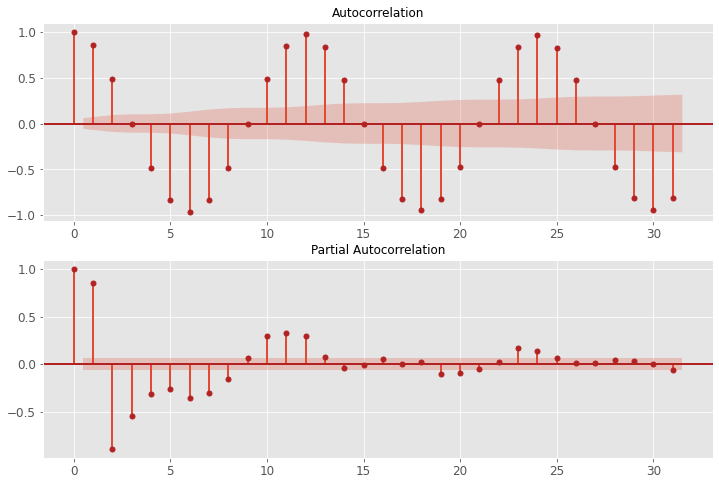

In [23]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(city_data.AverageTemperature, ax=ax1,color ='firebrick')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(city_data.AverageTemperature, ax=ax2,color='firebrick')

In [24]:
result = adfuller(city_data.AverageTemperature)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the entire dataset: -4.580250555577855
p-value: 0.00014044038964047565
Critical Values:
	1%: -3.4363635475753824
	5%: -2.864195245967465
	10%: -2.5681837404258903


In [25]:
result = adfuller(city_data.AverageTemperature[0:120])
print('ADF Statistic on the first decade: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the first decade: -2.0504609904707762
p-value: 0.2648950152931301
Critical Values:
	1%: -3.4924012594942333
	5%: -2.8886968193364835
	10%: -2.5812552709190673


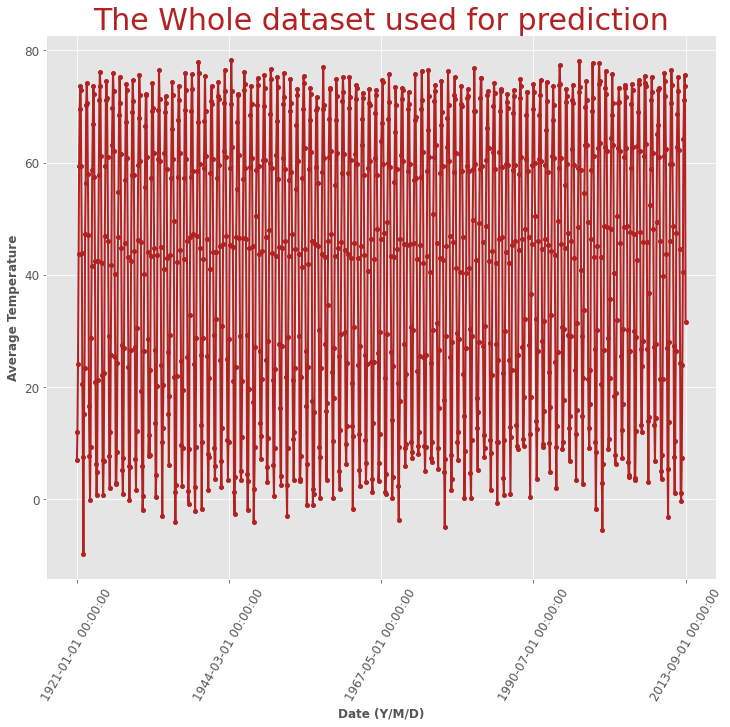

In [26]:
plt.title('The Whole dataset used for prediction', fontsize=30,color='firebrick')
plot_timeseries(1921,2013)

In [27]:
temp = get_timeseries(1921,2013)
N = len(temp.AverageTemperature)
split = 0.95
training_size = round(split*N)
test_size = round((1-split)*N)
series = temp.AverageTemperature[:training_size]
date = temp.dt[:training_size]
test_series = temp.AverageTemperature[len(date)-1:len(temp)]
test_date = temp.dt[len(date)-1:len(temp)]
test_date = test_date.reset_index().dt
test_series = test_series.reset_index().AverageTemperature

In [28]:
test_date

0    2009-01-01
1    2009-02-01
2    2009-03-01
3    2009-04-01
4    2009-05-01
5    2009-06-01
6    2009-07-01
7    2009-08-01
8    2009-09-01
9    2009-10-01
10   2009-11-01
11   2009-12-01
12   2010-01-01
13   2010-02-01
14   2010-03-01
15   2010-04-01
16   2010-05-01
17   2010-06-01
18   2010-07-01
19   2010-08-01
20   2010-09-01
21   2010-10-01
22   2010-11-01
23   2010-12-01
24   2011-01-01
25   2011-02-01
26   2011-03-01
27   2011-04-01
28   2011-05-01
29   2011-06-01
30   2011-07-01
31   2011-08-01
32   2011-09-01
33   2011-10-01
34   2011-11-01
35   2011-12-01
36   2012-01-01
37   2012-02-01
38   2012-03-01
39   2012-04-01
40   2012-05-01
41   2012-06-01
42   2012-07-01
43   2012-08-01
44   2012-09-01
45   2012-10-01
46   2012-11-01
47   2012-12-01
48   2013-01-01
49   2013-02-01
50   2013-03-01
51   2013-04-01
52   2013-05-01
53   2013-06-01
54   2013-07-01
55   2013-08-01
56   2013-09-01
Name: dt, dtype: datetime64[ns]

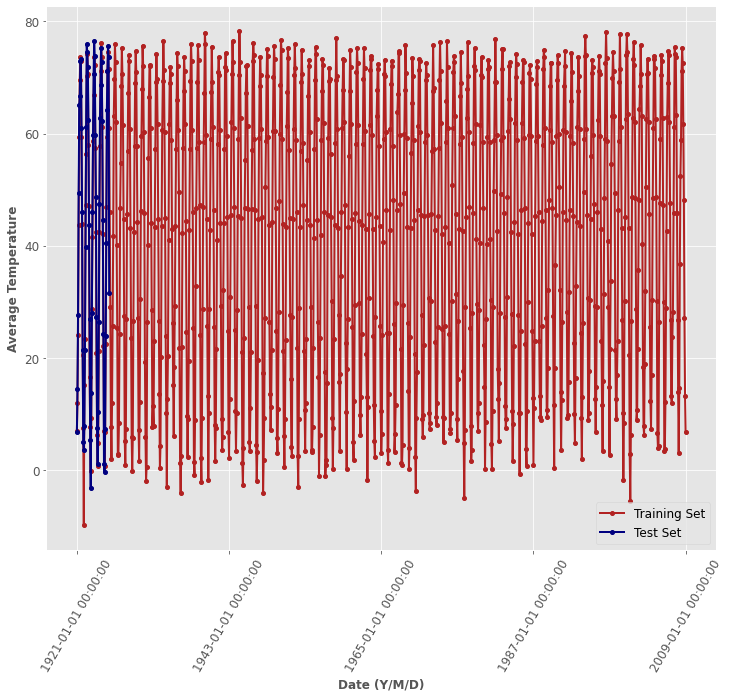

In [29]:
plot_from_data(series,date,label='Training Set')
plot_from_data(test_series,test_date,'navy',with_ticks=False,label='Test Set')
plt.legend()

# Finding the optimal parameters

In [30]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        #try: 
        model = SARIMAX(exog, order=order).fit(disp=-1)
    #except:
    #        continue
            
        aic = model.aic
        results.append([order, model.aic])
    #print(results)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [31]:
ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_0 = optimize_ARIMA(order_list, exog = series)


C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization fa

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

In [32]:
result_d_0.head()

,"(p, d, q)",AIC
0,"(6, 0, 9)",5376.899256
1,"(9, 0, 8)",5381.025361
2,"(6, 0, 8)",5392.525831
3,"(6, 0, 7)",5405.232389
4,"(8, 0, 9)",5406.010622


In [33]:
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_1 = optimize_ARIMA(order_list, exog = series)

result_d_1

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization fa

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

,"(p, d, q)",AIC
0,"(5, 1, 7)",5381.154790
1,"(8, 1, 8)",5388.904661
2,"(9, 1, 9)",5395.548310
3,"(7, 1, 7)",5395.910816
4,"(7, 1, 9)",5401.638472
...,...,...
95,"(1, 1, 1)",7554.505864
96,"(0, 1, 2)",7568.893469
97,"(1, 1, 0)",7609.520067
98,"(0, 1, 1)",7906.345234


In [34]:
result_d_1.head()

,"(p, d, q)",AIC
0,"(5, 1, 7)",5381.154790
1,"(8, 1, 8)",5388.904661
2,"(9, 1, 9)",5395.548310
3,"(7, 1, 7)",5395.910816
4,"(7, 1, 9)",5401.638472


In [35]:
final_result = result_d_0.append(result_d_1)

In [36]:
best_models = final_result.sort_values(by='AIC', ascending=True).reset_index(drop=True).head()

In [37]:
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_params_1 = best_models[best_models.columns[0]][1]

In [38]:
best_model_0 = SARIMAX(series, order=best_model_params_0).fit()
print(best_model_0.summary())
best_model_1 = SARIMAX(series, order=best_model_params_1).fit()
print(best_model_1.summary())

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                 1057
Model:               SARIMAX(6, 0, 9)   Log Likelihood               -2672.450
Date:                Tue, 16 Nov 2021   AIC                           5376.899
Time:                        13:57:15   BIC                           5456.310
Sample:                             0   HQIC                          5407.000
                               - 1057                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7441      0.001   4412.973      0.000       2.743       2.745
ar.L2         -2.7775      0.002  -1722.555      0.000      -2.781      -2.774
ar.L3          0.0800      0.002     32.071      0.0

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


# Model (2,1,5) results:

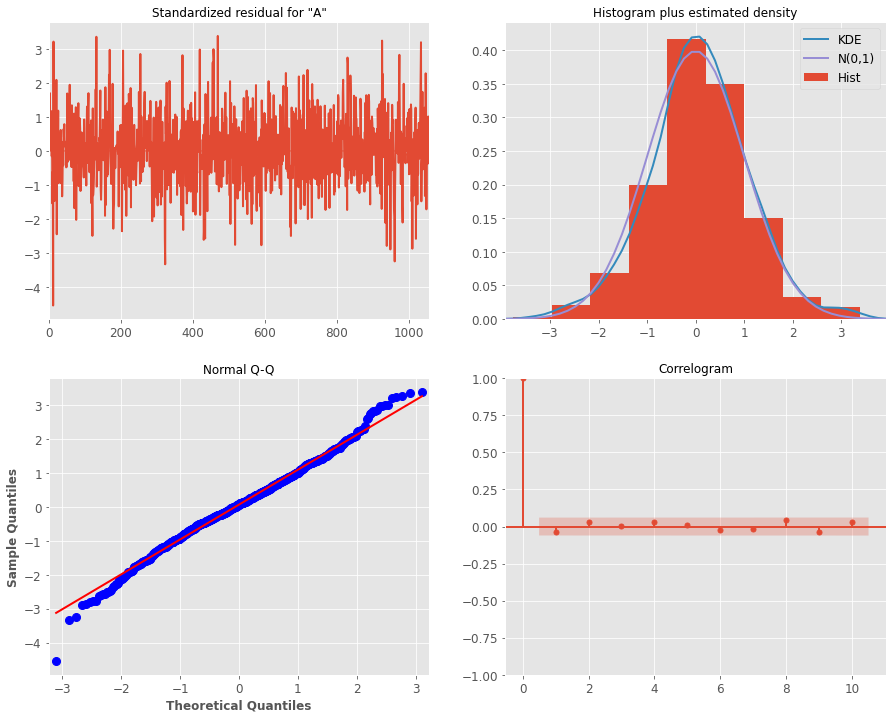

In [39]:
best_model_0.plot_diagnostics(figsize=(15,12))
plt.show()

# Model (2,1,6) results:

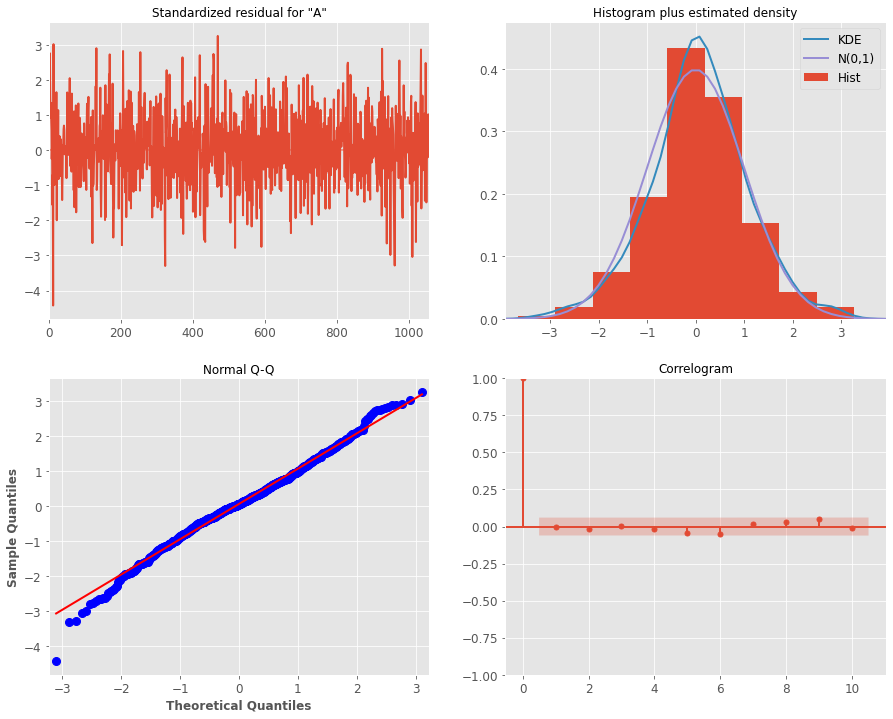

In [40]:
best_model_1.plot_diagnostics(figsize=(15,12))
plt.show()

## Forecasting

In [41]:
fore_l= test_size-1
forecast = best_model_0.get_prediction(start=training_size, end=training_size+fore_l)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

s_forecast = best_model_1.get_prediction(start=training_size, end=training_size+fore_l)
s_forec = s_forecast.predicted_mean
s_ci = forecast.conf_int(alpha=0.05)

In [42]:

error_test=city_data.loc[test_date[1:].index.tolist()].AverageTemperatureUncertainty
index_test = test_date[1:].index.tolist()
test_set = test_series[1:]

In [43]:
lower_test = test_set-error_test
upper_test = test_set+error_test

In [44]:
print(forec)

1057    13.572092
1058    30.314928
1059    47.653652
1060    62.547120
1061    70.695739
1062    74.637456
1063    71.619385
1064    62.687808
1065    45.599608
1066    26.549680
1067    10.485894
1068     6.267492
1069    13.487156
1070    30.289721
1071    47.696860
1072    62.506384
1073    70.744514
1074    74.602996
1075    71.657593
1076    62.631151
1077    45.616733
1078    26.494633
1079    10.524647
1080     6.241360
1081    13.538586
1082    30.258741
1083    47.734282
1084    62.471620
1085    70.787411
1086    74.574307
1087    71.690043
1088    62.580150
1089    45.628301
1090    26.445131
1091    10.557957
1092     6.220584
1093    13.584680
1094    30.233005
1095    47.766547
1096    62.441995
1097    70.825255
1098    74.550577
1099    71.717539
1100    62.534011
1101    45.635093
1102    26.400403
1103    10.586589
1104     6.204411
1105    13.626182
1106    30.211779
1107    47.794384
1108    62.416791
1109    70.858752
1110    74.531105
1111    71.740771
1112    62

In [45]:
s_forec

1057    14.855297
1058    30.526861
1059    47.931832
1060    61.865573
1061    71.038353
1062    74.589591
1063    72.570969
1064    62.266294
1065    45.420178
1066    25.541494
1067    10.580949
1068     6.550992
1069    14.633013
1070    30.479994
1071    48.006234
1072    61.811514
1073    71.039921
1074    74.700448
1075    72.355638
1076    62.403054
1077    45.262927
1078    25.555712
1079    10.658237
1080     6.486697
1081    14.697711
1082    30.507116
1083    47.910423
1084    61.965291
1085    70.937099
1086    74.750563
1087    72.346572
1088    62.281913
1089    45.300289
1090    25.517938
1091    10.639420
1092     6.598916
1093    14.608411
1094    30.580243
1095    47.903758
1096    61.937093
1097    71.021987
1098    74.692725
1099    72.323183
1100    62.277625
1101    45.187907
1102    25.581321
1103    10.620791
1104     6.609875
1105    14.670370
1106    30.525830
1107    47.942892
1108    61.959872
1109    70.992414
1110    74.749407
1111    72.244737
1112    62

# Plotting Our Predictions
#### Prediction 1

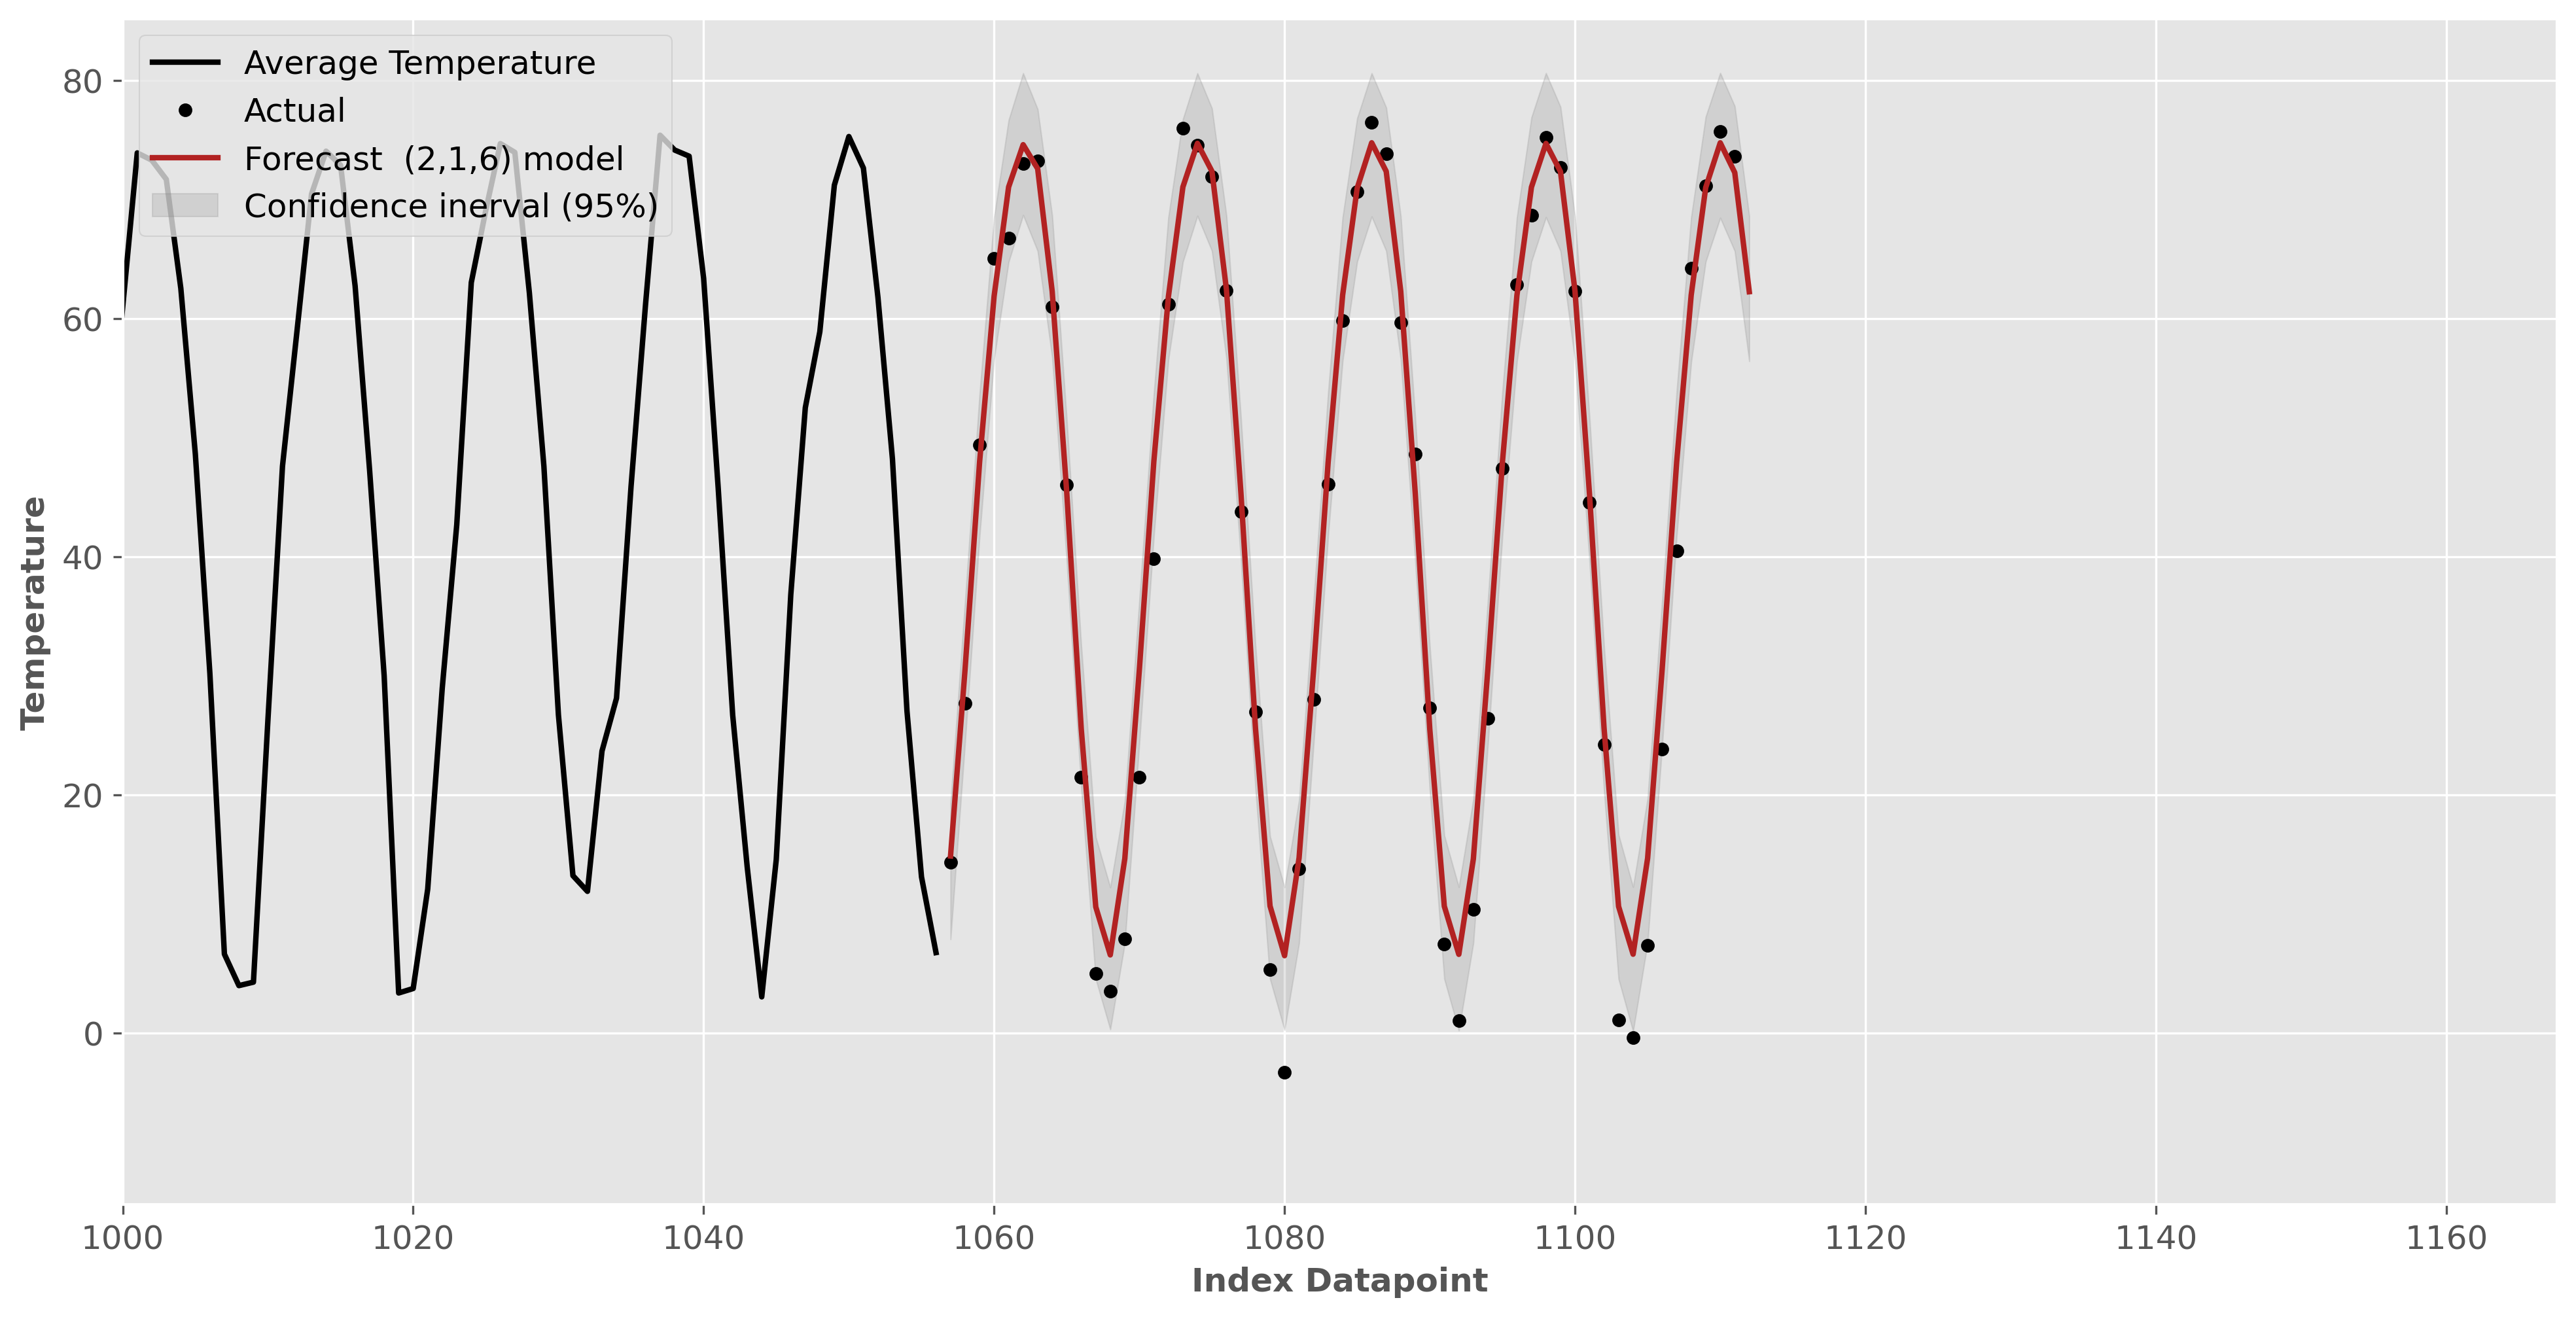

In [46]:
fig, ax = plt.subplots(figsize=(16,8), dpi=300)
x0 = city_data.AverageTemperature.index[0:training_size]
x1=city_data.AverageTemperature.index[training_size:training_size+fore_l+1]
plt.plot(x0, city_data.AverageTemperature[0:training_size],'k', label = 'Average Temperature')
plt.plot(city_data.AverageTemperature[training_size:training_size+fore_l], '.k', label = 'Actual')
#forec.plot(ax=ax,color = 'Darkorange',label = 'Forecast (d = 2)')
#ax.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

s_forec.plot(ax=ax,color = 'firebrick',label = 'Forecast  (2,1,6) model')
ax.fill_between(x1, s_ci['lower AverageTemperature'], s_ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')


plt.legend(loc = 'upper left')
plt.xlim(1000,)
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
plt.show()

# Plotting Our Predictions
#### Prediction 2

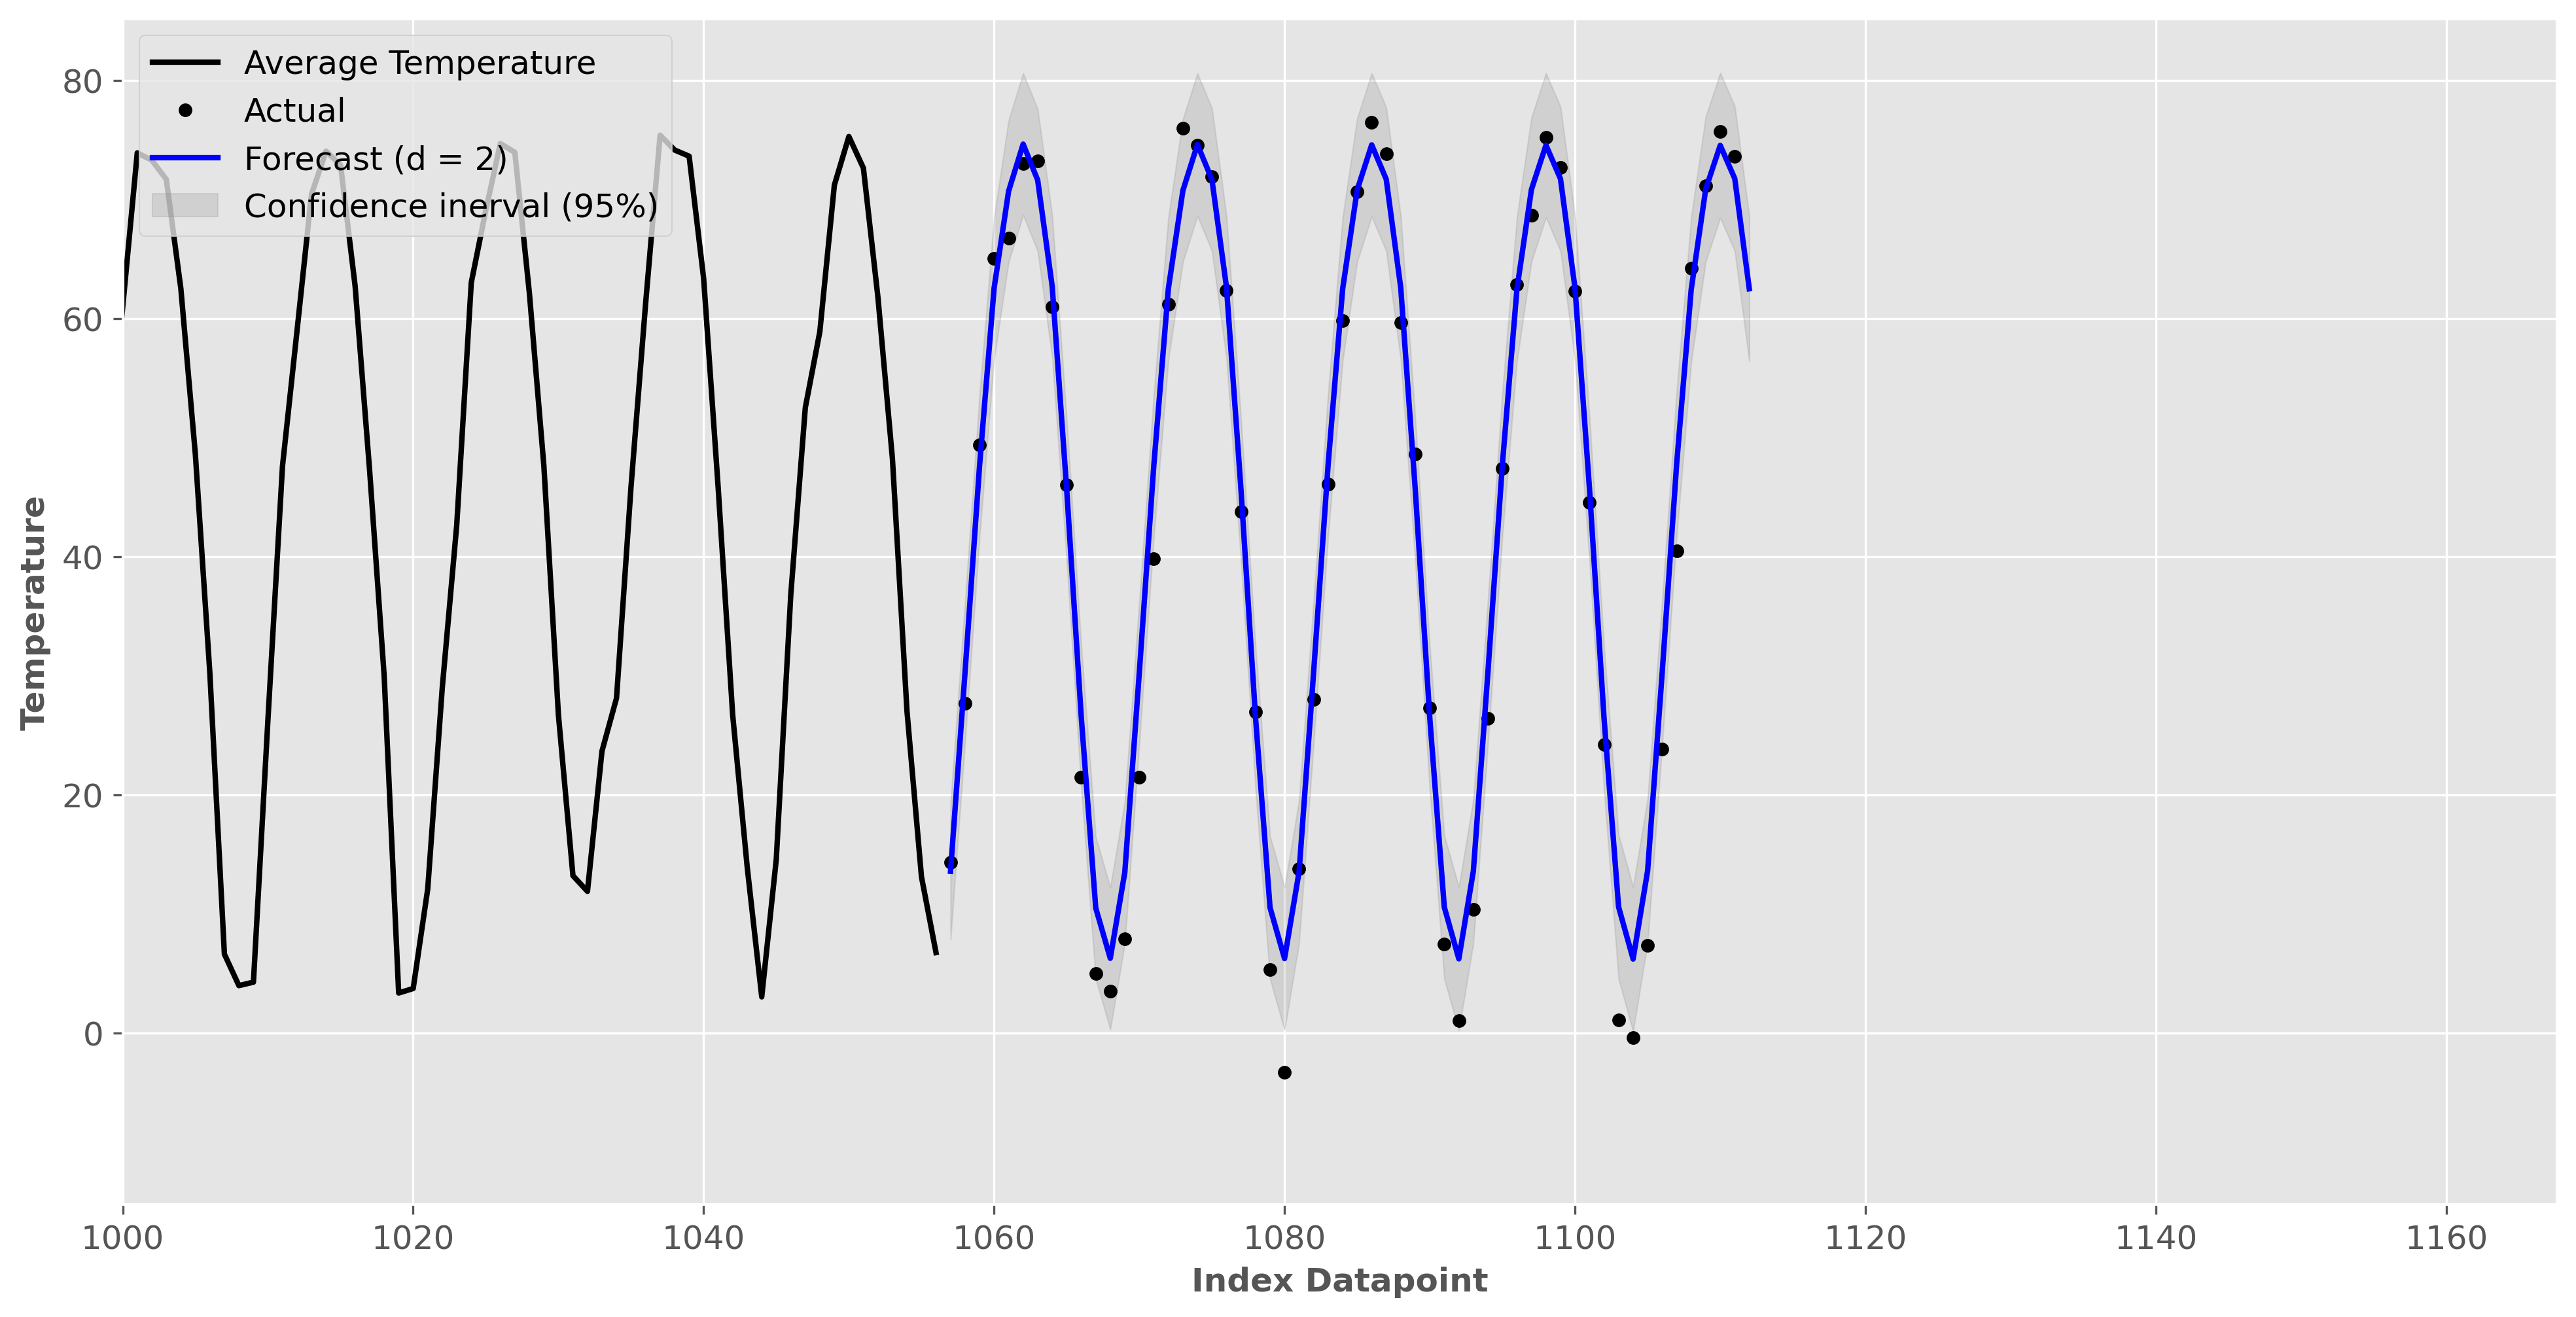

In [47]:
fig, ax = plt.subplots(figsize=(16,8), dpi=300)
x0 = city_data.AverageTemperature.index[0:training_size]
x1=city_data.AverageTemperature.index[training_size:training_size+fore_l+1]
plt.plot(x0, city_data.AverageTemperature[0:training_size],'k', label = 'Average Temperature')
plt.plot(city_data.AverageTemperature[training_size:training_size+fore_l], '.k', label = 'Actual')
forec.plot(ax=ax,color = 'Blue',label = 'Forecast (d = 2)')
ax.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

plt.legend(loc = 'upper left')
plt.xlim(1000,)
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
plt.show()

# Prediction Comparison

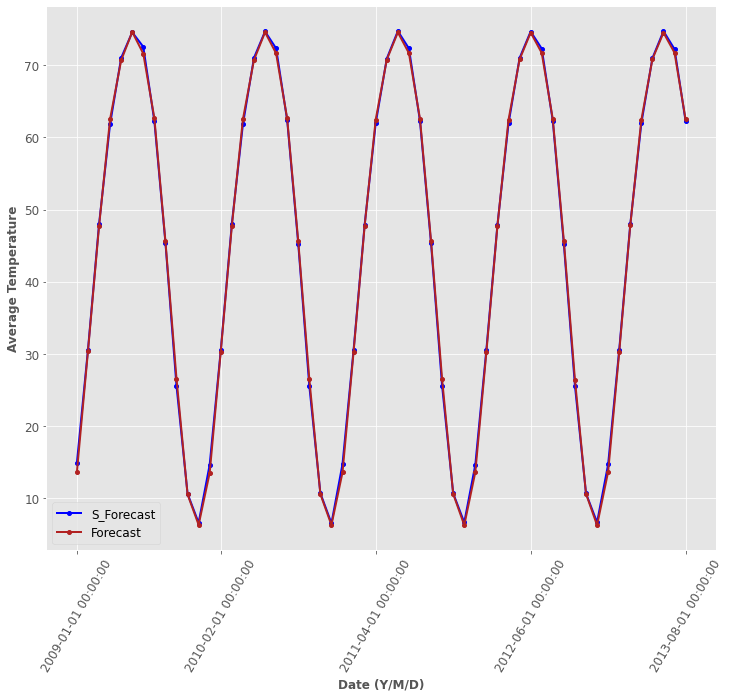

In [48]:
plot_from_data(s_forec,test_date,c='blue',label='S_Forecast')
plot_from_data(forec,test_date,c='firebrick',label='Forecast')
plt.legend(loc=3)

# Prediction 1 Vs Actual

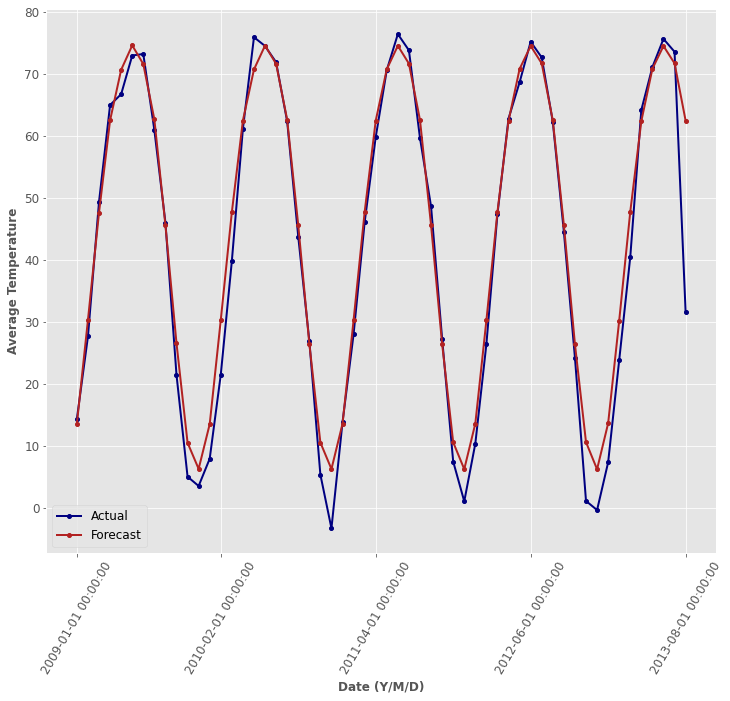

In [49]:
plot_from_data(test_set,test_date,c='navy',label='Actual')
plot_from_data(forec,test_date,c='firebrick',label='Forecast')
plt.legend(loc=3)

# Prediction 2 Vs Actual

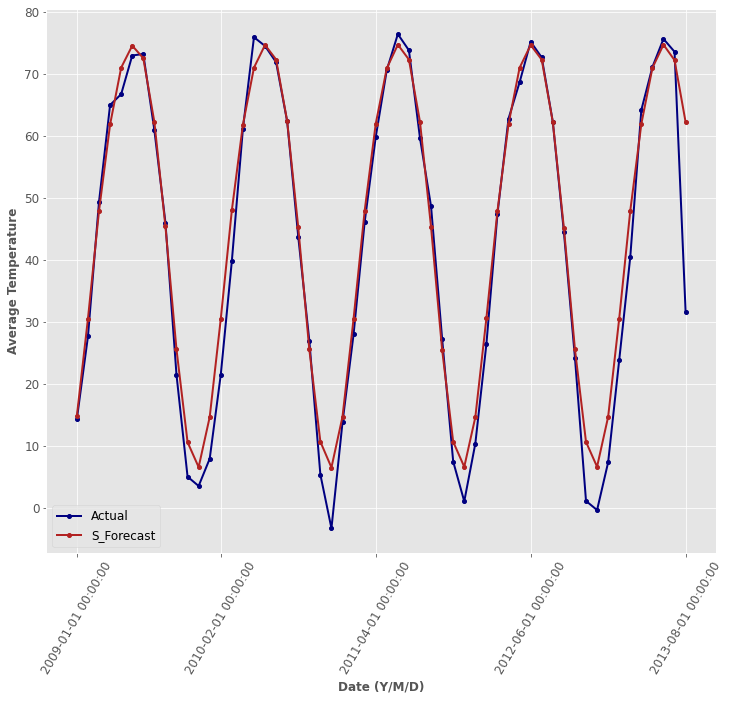

In [50]:
plot_from_data(test_set,test_date,c='navy',label='Actual')
plot_from_data(s_forec,test_date,c='firebrick',label='S_Forecast')
plt.legend(loc=3)

# Recreating DataFrame

In [51]:
df = pd.DataFrame(forec)
df.head()

,predicted_mean
1057,13.572092
1058,30.314928
1059,47.653652
1060,62.547120
1061,70.695739


In [52]:
df["s_forec"] = list(s_forec)


In [53]:
df= df.rename(columns={"predicted_mean": "forec"})

In [55]:
df["average_predicted"] = (df.forec + df.s_forec) / 2


In [56]:
df["City"] = city
df.head()

,forec,s_forec,average_predicted,City
1057,13.572092,14.855297,14.213694,Changchun
1058,30.314928,30.526861,30.420894,Changchun
1059,47.653652,47.931832,47.792742,Changchun
1060,62.547120,61.865573,62.206346,Changchun
1061,70.695739,71.038353,70.867046,Changchun


In [57]:
dt_df = pd.DataFrame(test_date)
dt_df.tail()

,dt
52,2013-05-01
53,2013-06-01
54,2013-07-01
55,2013-08-01
56,2013-09-01


In [58]:
test_dates = dt_df.dt.values


In [59]:
test_dates = test_dates[0:-1]

In [60]:
df["dt"] = test_dates
df.head()

,forec,s_forec,average_predicted,City,dt
1057,13.572092,14.855297,14.213694,Changchun,2009-01-01
1058,30.314928,30.526861,30.420894,Changchun,2009-02-01
1059,47.653652,47.931832,47.792742,Changchun,2009-03-01
1060,62.547120,61.865573,62.206346,Changchun,2009-04-01
1061,70.695739,71.038353,70.867046,Changchun,2009-05-01


In [61]:
df["AverageTemperature"] = list(test_set)

In [66]:
df= df[['dt','City','AverageTemperature','forec', 's_forec']]
df

,dt,City,AverageTemperature,forec,s_forec
1057,2009-01-01,Changchun,14.3456,13.572092,14.855297
1058,2009-02-01,Changchun,27.6530,30.314928,30.526861
1059,2009-03-01,Changchun,49.3862,47.653652,47.931832
1060,2009-04-01,Changchun,65.0138,62.547120,61.865573
1061,2009-05-01,Changchun,66.7580,70.695739,71.038353
1062,2009-06-01,Changchun,73.0004,74.637456,74.589591
1063,2009-07-01,Changchun,73.2452,71.619385,72.570969
1064,2009-08-01,Changchun,60.9620,62.687808,62.266294
1065,2009-09-01,Changchun,46.0346,45.599608,45.420178
1066,2009-10-01,Changchun,21.4448,26.549680,25.541494


# Export City as CSV

In [ ]:
df.to_csv("{city}data.csv')